In [1]:
#Computação científica
import numpy as np

#análise de dados
import pandas as pd

#machine learning
from sklearn.linear_model import LogisticRegression #regressão lasso
from sklearn.model_selection import GridSearchCV, KFold
import lightgbm as lgb


#mtricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve


#visualização
import matplotlib.pyplot as plt
import seaborn as sns



#pipeline
from imblearn.pipeline import Pipeline

#cross validation
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm




/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#Parâmetros

In [2]:
#Definir a seed para que os resultados obtidos sejam sempre os mesmos

seed=0

In [3]:
#Estilo dos gráficos do seaborn

sns.set_theme(style="darkgrid")


# Carregar *Dados*

In [4]:
path='/content/drive/MyDrive/Rodolfo/porto/porto-seguro-safe-driver-prediction/'



Será usado o dataset com as features selecionadas através da correlação, de acordo com os resultados obtidos no notebook de tuning

In [5]:
#Dados com colunas selecionadas através do calculo da correlação

x_train = pd.read_csv(path+'train_selected_features_transformed.csv')
x_val   = pd.read_csv(path+'val_selected_features_transformed.csv')

y_train = np.ravel(pd.read_csv(path+'y_train.csv'))
y_val   = np.ravel(pd.read_csv(path+'y_val.csv'))

print("Número de features: {}".format(np.shape(x_train)[1]))

Número de features: 108


# Funções para treinamento dos modelos

In [6]:
#Função para treinar modelo com stratifiedkfold
def calcular_auc_stratifiedkfold(model,x,y,n_splits=10):
  """
  Função para treinar um modelo com o uso de stratifiedkfold e retornar uma lista com
  o roc_auc score para os dados de cada uma das folds

  Inputs:
    model    - instância de um objeto. O objeto é um modelo que será usado no treinamento
    x        - (pandas dataframe) dados de entrada do modelo
    y        - (np array) output esperado do moldelo
    n_splits - (int) número de splits usadas na validação cruzada

  Outputs
    auc     - (list) lista com o auc score obtido com os dados separados para teste na validação cruzada
   """

  #criação de objeto stratifiedkfold
  skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
  auc=[]
  progress_bar = tqdm(total=n_splits)
  for train_index, test_index in skf.split(x, y):
      x_train_fold, x_test_fold = x.loc[train_index,:], x.loc[test_index,:]
      y_train_fold, y_test_fold = y[train_index], y[test_index]
      model.fit(x_train_fold, y_train_fold)
      auc.append(roc_auc_score(y_test_fold,model.predict_proba(x_test_fold)[:,1]))
      progress_bar.update(1)
  return auc

In [7]:
def treinar_modelos_feature_selection(modelo,x,y,feature_importance,quantiles=[0,0.25,0.5,0.75],feature_importance_column='Coefficient',feature_name_column='Feature'):
  '''
  Função para treinar um modelo com datasets contendo diferentes números de features. As features contidadas em cada dataset serão selecionadas de acordo com valores de feature
  importance previamente calculadas

  Inputs:
    modelo - intância de um objeto que será treinado com os diferentes datasets
    x      - pandas dataframe com o dataset com todas as features iniciais
    y      - numpy array com output esperados
    feature_importance - panda dataframe com duas colunas: na coluna feature_name_column estão os nomes das features e na coluna feature_importance_column estão os valores
                         das features importances de cada coluna
    quantiles - (list) valores que serão usados para seleção das features. Por exemplo, se quantile=0.5 então somente serão usadas as features com feature importance superior a mediana.
                O padrão de quantiles é  [0,0.25,0.5,0.75]. Isso significa que o modelo será treinado com todas as features com feature importance superior a zero, em seguida com as com feature
                importance superiores ao primeiro qurtil e assim sucessivamente
    feature_importance_column - string com o nome da coluna no dataframe feature_importance que contém os valores das feature importance de cada feature
    feature_name_column       - string com o nome da coluna no dataframe com o nome das features
  '''
  initial_n_features=0
  resultados={} #resultados com logistic regression partindo do dados com todas as features
  for q in quantiles:
    threshold = feature_importance[feature_importance_column].quantile(q) #definição de um threhold
    selected_features =feature_importance.loc[feature_importance[feature_importance_column]>=threshold,feature_name_column] # features com coeficientes inferiores ao thresold definido
                                                                                                                            # não serão usadas
    selected_features = selected_features.to_list()
    x_selected=x.loc[:,selected_features]
    n_selected=len(selected_features)
    if initial_n_features!=n_selected: #teste necessário para evitar que o modelo seja treinado duas vezes com as mesma features
      initial_n_features=n_selected
      print('')
      print('Número de features selecionadas: {}'.format(n_selected))
      resultados[str(n_selected)+'_features']=calcular_auc_stratifiedkfold(modelo,x_selected,y)
  return resultados


# Logistic Regression

In [8]:
#Dowload dos melhores parâmetros para o modelo encontrados na etapa anterior
best_parameters_lr = np.load(path+'/best_parameters_lr.npy',allow_pickle='TRUE').item()


In [9]:
#definição do modelo
logistic_model = LogisticRegression(random_state=seed,solver='saga',max_iter=1000,**best_parameters_lr)


In [10]:
#treinar modelo para  obter valores dos coeficientes
logistic_model.fit(x_train,y_train)

LogisticRegression(C=0.01924040630345381, max_iter=1000, random_state=0,
                   solver='saga')

In [11]:
# Valores dos coeficientes da regressão
coefficients_lr = logistic_model.coef_[0]

#criação de um dataframe com os valores dos coeficientes da regressão
feature_importance_lr = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': coefficients_lr})

#ordenar os coeficientes de acordo com os maiores valores absolutos
feature_importance_lr['Coefficient']=feature_importance_lr['Coefficient'].abs()
feature_importance_lr.sort_values(by='Coefficient',ascending=False,inplace=True)

feature_importance_lr.describe()

,Coefficient
count,108.000000
mean,0.079343
std,0.070302
min,0.000213
25%,0.024356
50%,0.063057
75%,0.109549
max,0.367361


<Axes: xlabel='Coefficient', ylabel='Feature'>

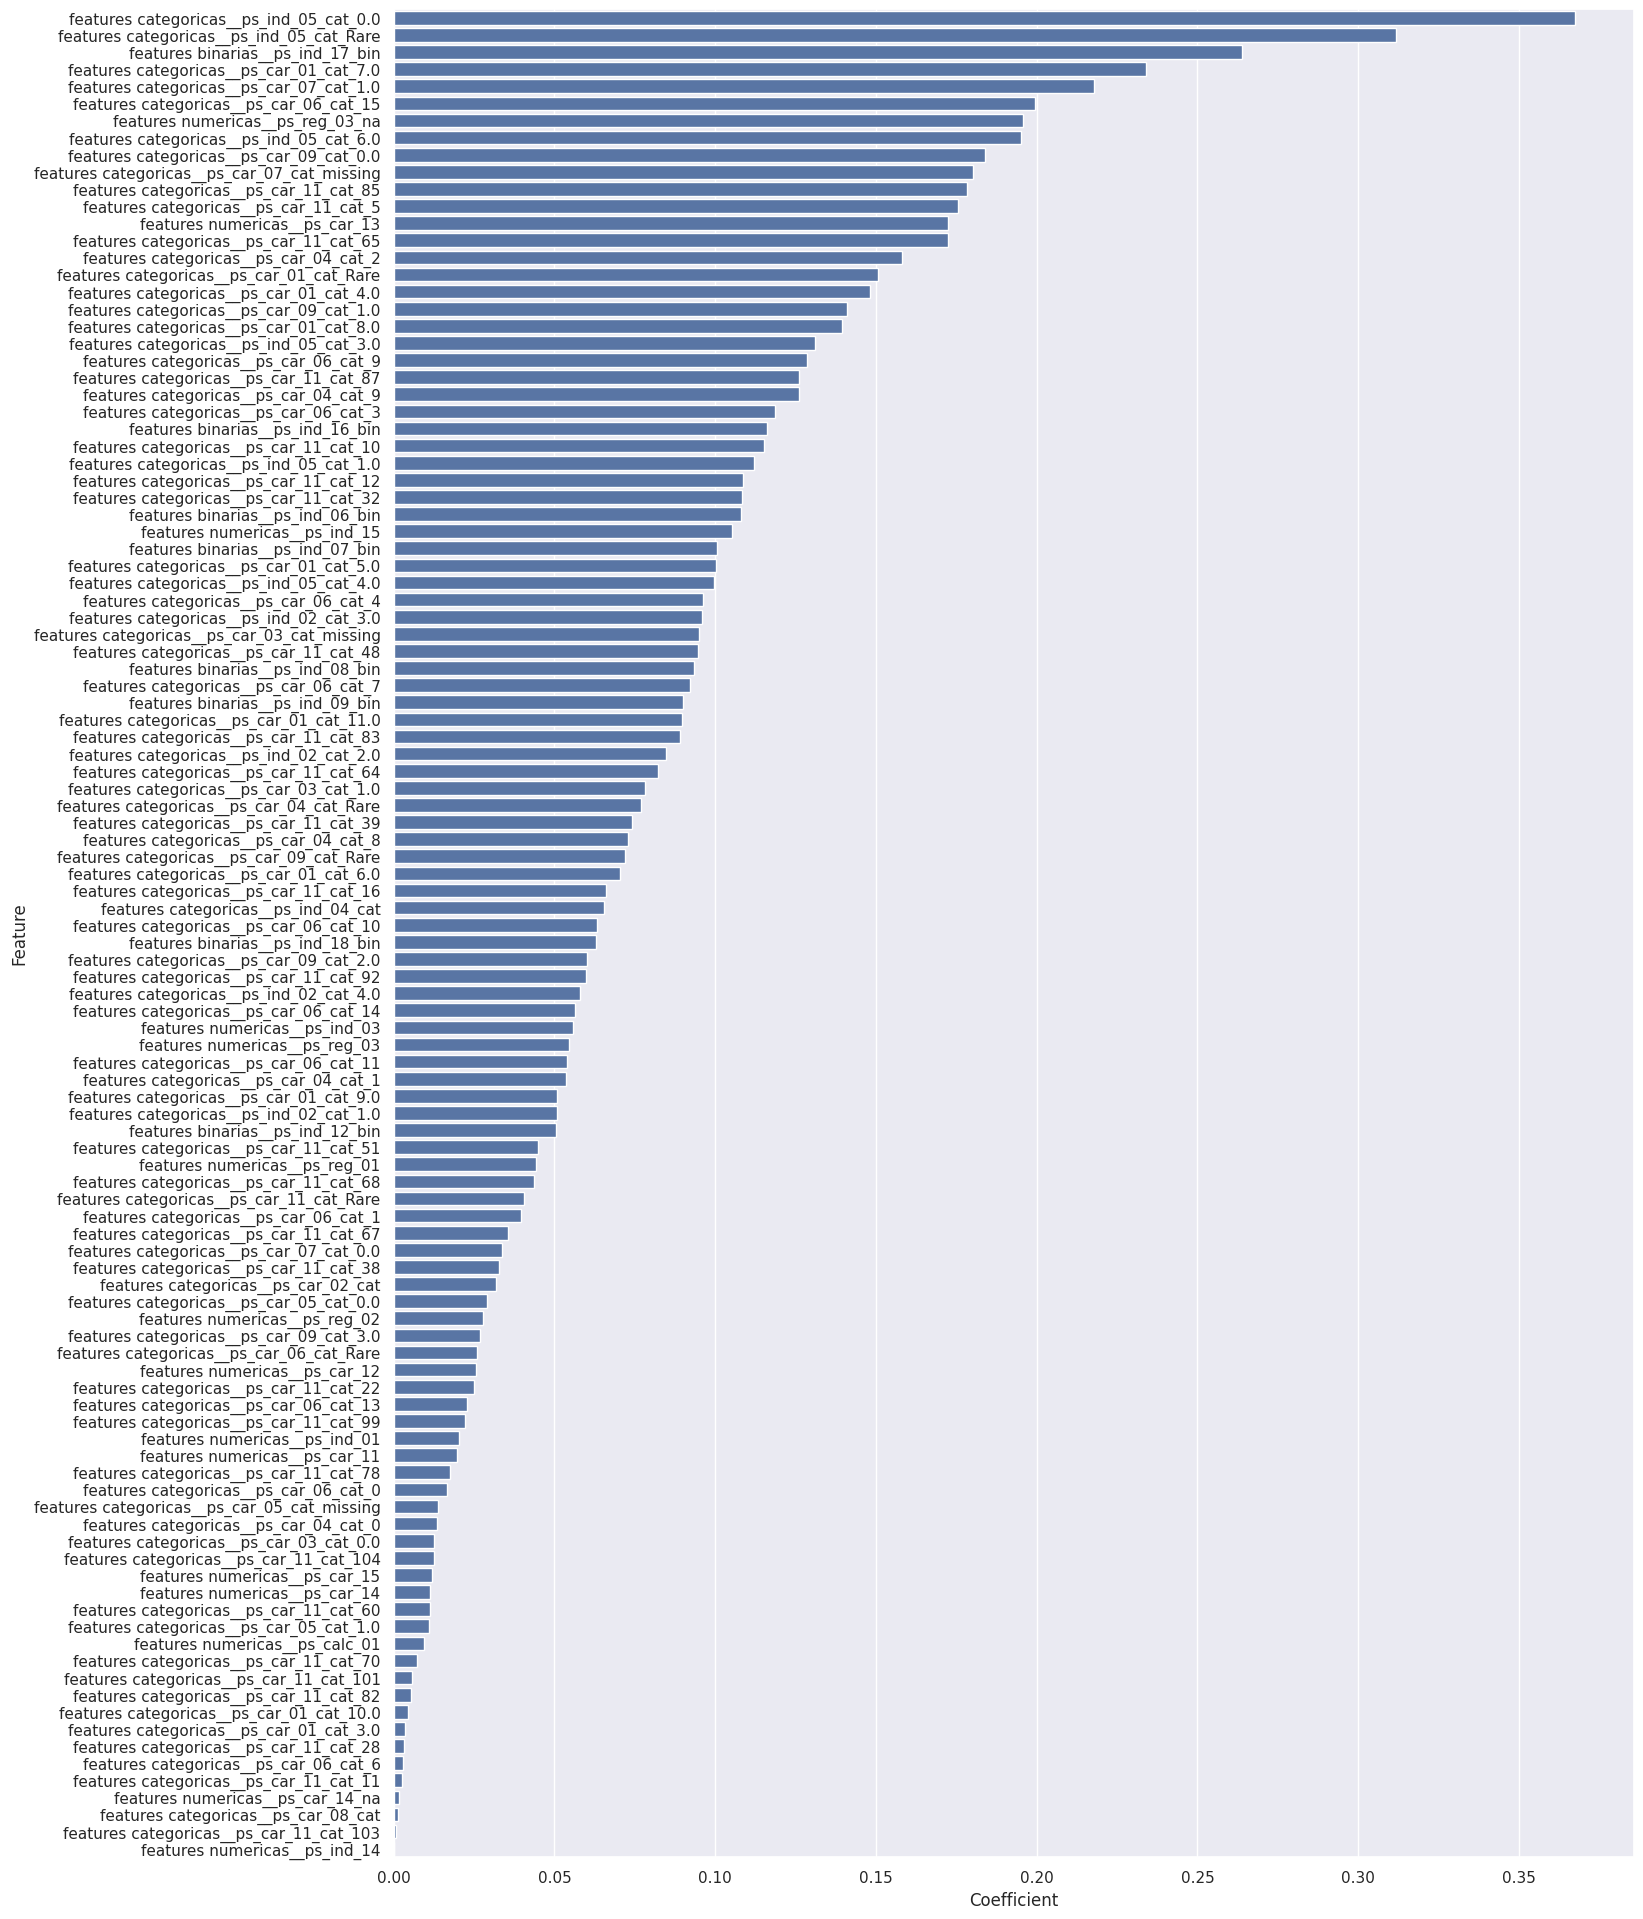

In [12]:
plt.figure(figsize=(16,24))
sns.barplot(x='Coefficient',y='Feature',data=feature_importance_lr,orient='h')

<Axes: xlabel='Coefficient'>

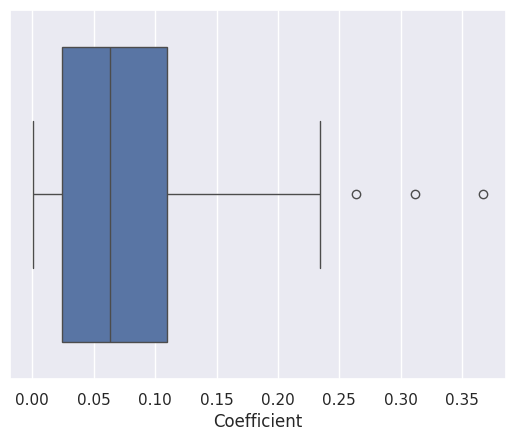

In [13]:
#BoxPlot com valores dos coeficientes
sns.boxplot(data=feature_importance_lr,x='Coefficient')


In [14]:
#Treinar regressão logśtica com somente parte das features
#As features usadas serão selecionadas de acordos com os valores de seus coeficientes. As features mais importantes tem coeficientes maiores
#Por exemplo, se quantile=0.5 somente serão usadas as features cujos coeficientes tenham valores acima da mediana dos coeficientes

resultados_lr=treinar_modelos_feature_selection(logistic_model,x_train,y_train,feature_importance_lr,quantiles=[0,0.25,0.5,0.75])


Número de features selecionadas: 108


100%|██████████| 10/10 [29:23<00:00, 176.33s/it]



Número de features selecionadas: 81


100%|██████████| 10/10 [04:43<00:00, 28.39s/it]



Número de features selecionadas: 54


100%|██████████| 10/10 [01:36<00:00,  9.61s/it]



Número de features selecionadas: 27


100%|██████████| 10/10 [00:55<00:00,  5.59s/it]


Text(0, 0.5, 'ROC AUC')

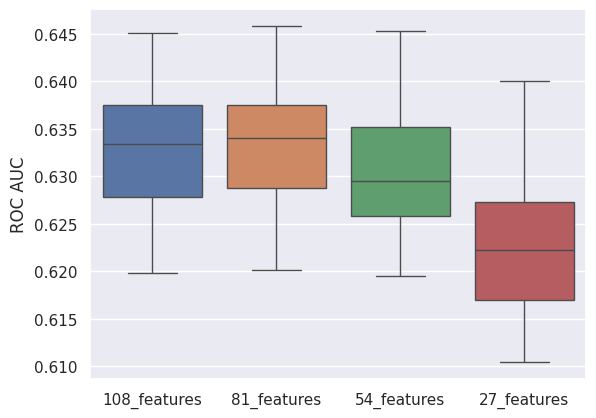

In [15]:
resultados_lr=pd.DataFrame(resultados_lr)
sns.boxplot(resultados_lr)
plt.ylabel("ROC AUC")

In [16]:
resultados_lr.describe()

,108_features,81_features,54_features,27_features
count,10.000000,10.000000,10.000000,10.000000
mean,0.632760,0.633428,0.630369,0.622359
std,0.007301,0.007312,0.007510,0.008710
min,0.619787,0.620170,0.619526,0.610472
25%,0.627877,0.628793,0.625844,0.616992
50%,0.633382,0.634058,0.629487,0.622286
75%,0.637477,0.637525,0.635179,0.627304
max,0.645122,0.645860,0.645290,0.640025


Melhores Resultados:

1.   108 features
2.   81 features



# LightGBM

In [17]:
#carregar os melhores parâmetros encontrados
best_parameters_lgb = np.load(path+'/best_parameters_lgb.npy',allow_pickle='TRUE').item()

In [18]:
#definir modelo
lgb_model = lgb.LGBMClassifier(importance_type='gain',**best_parameters_lgb)

In [19]:
#treinar modelo para  obter valores dos coeficientes
lgb_model.fit(x_train,y_train)

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 15186, number of negative: 401462
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 416648, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036448 -> initscore=-3.274739
[LightGBM] [Info] Start training from score -3.274739


LGBMClassifier(colsample_bytree=0.41369994989274667, importance_type='gain',
               learning_rate=0.004016609229734623, min_data_in_leaf=52,
               n_estimators=813, num_leaves=86, subsample=0.19892371972444625)

In [20]:
#criação de dataframe com as feature importances

feature_importance_lgb = lgb_model.feature_importances_
feature_importance_lgb=pd.DataFrame({'Feature':x_train.columns,'Feature Importance':feature_importance_lgb})
feature_importance_lgb=feature_importance_lgb.sort_values(by='Feature Importance',ascending=False)

<Axes: xlabel='Feature Importance', ylabel='Feature'>

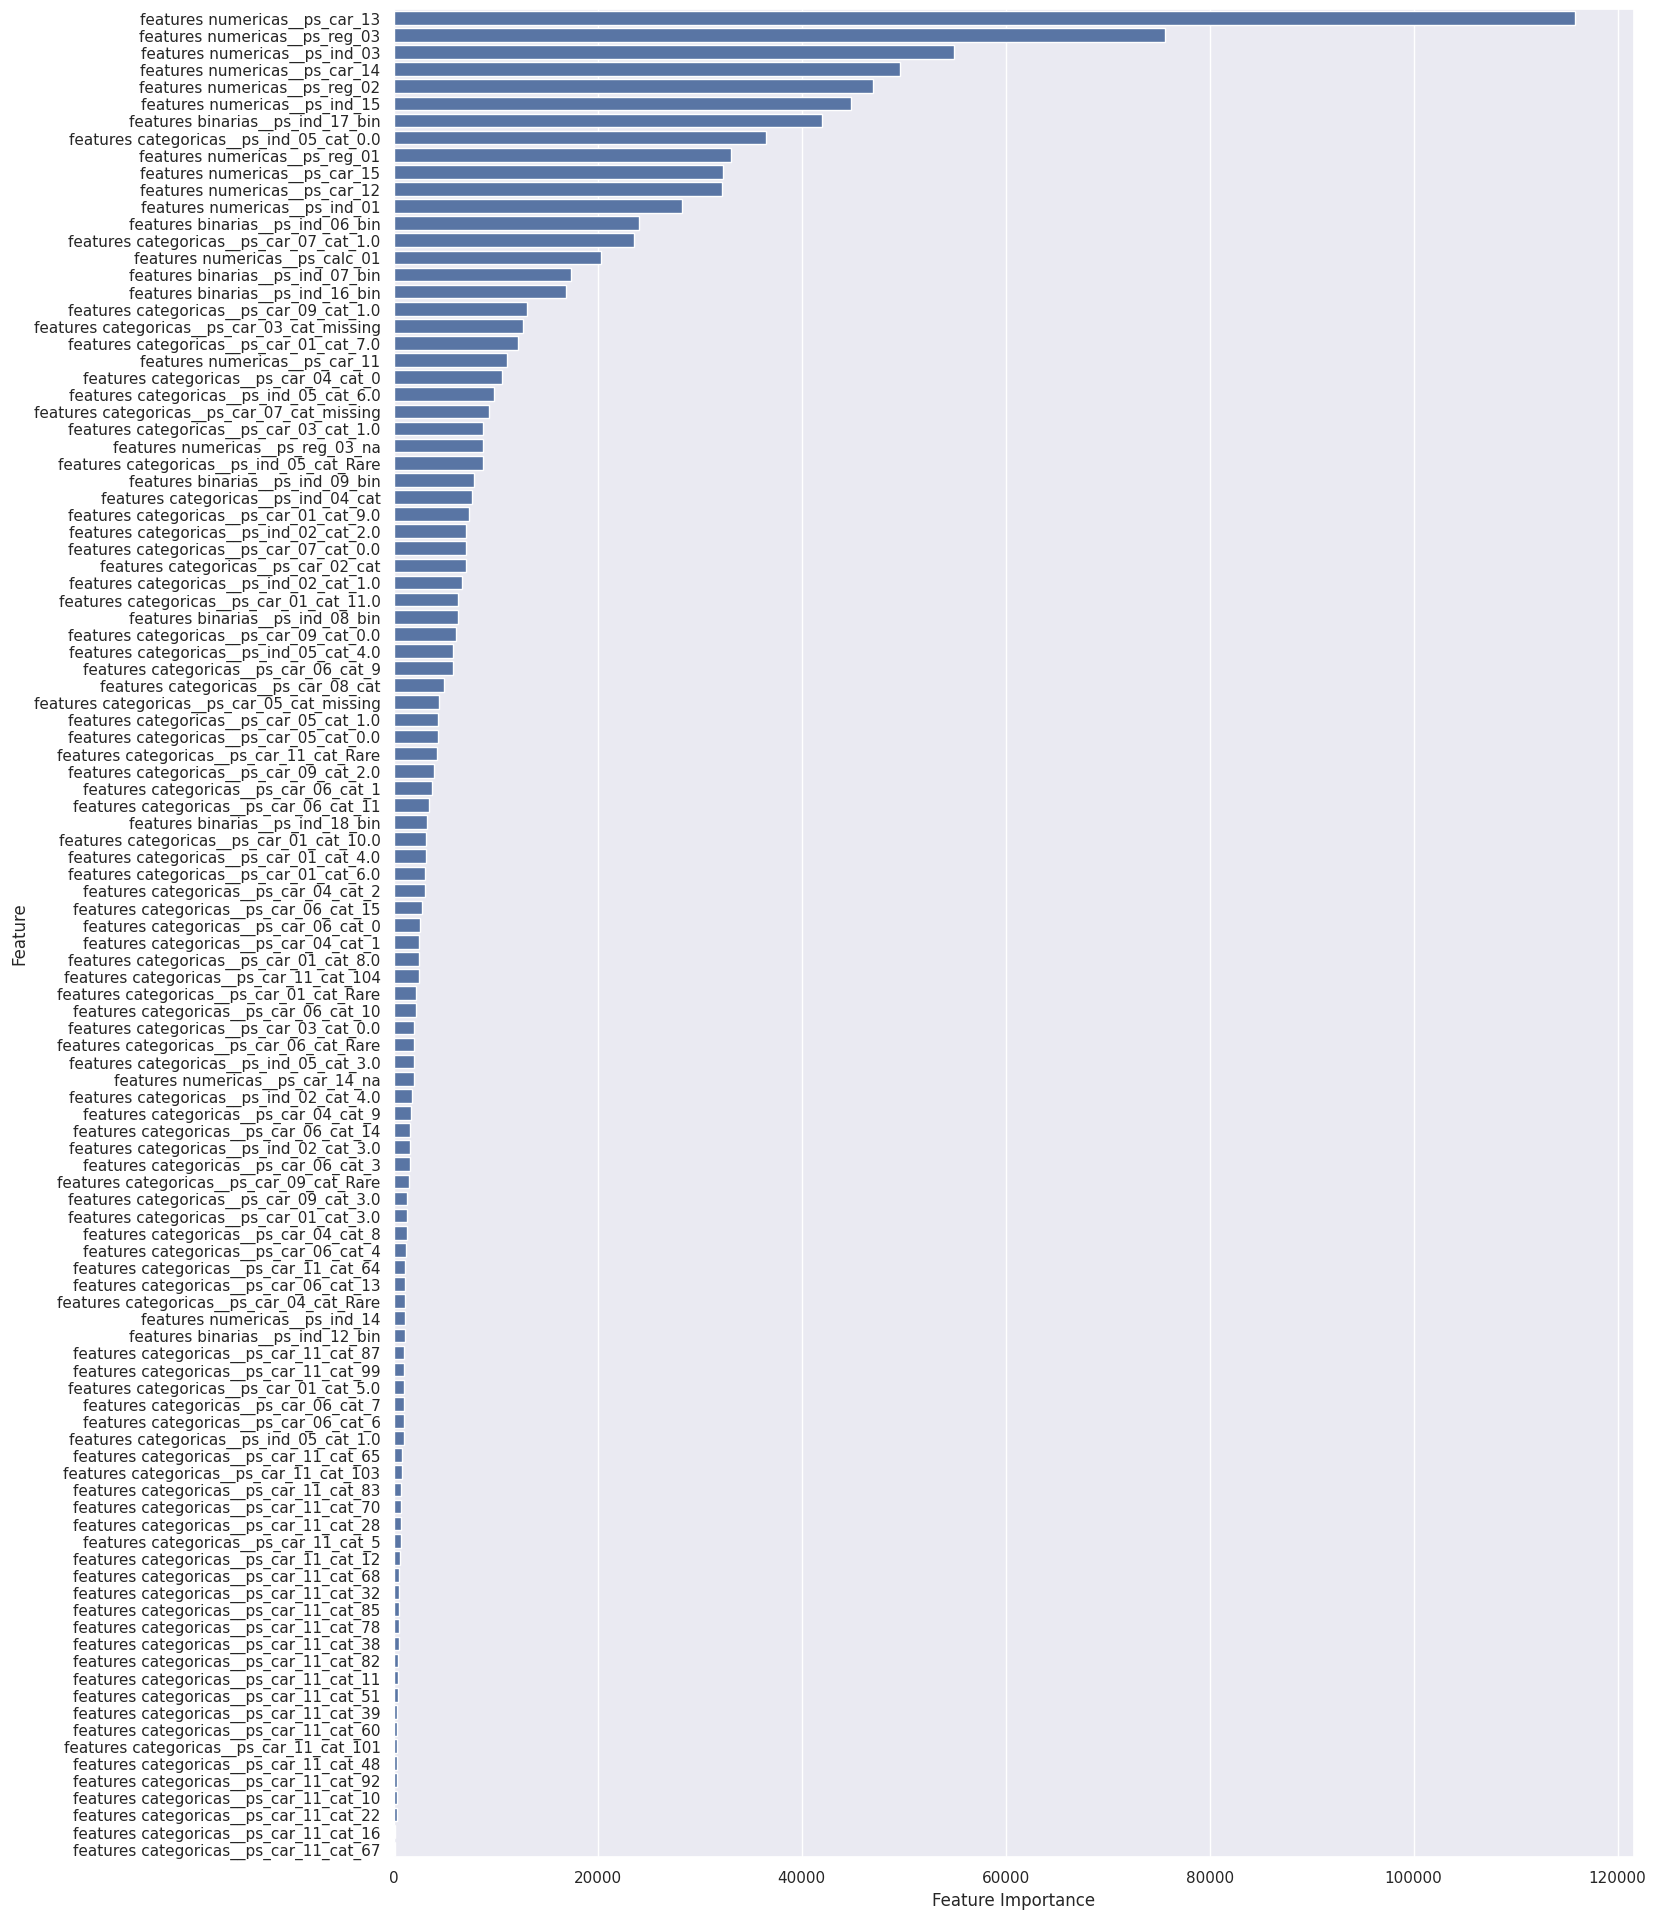

In [21]:
plt.figure(figsize=(16,24))
sns.barplot(x='Feature Importance',y='Feature',data=feature_importance_lgb,orient='h')

<Axes: xlabel='Feature Importance'>

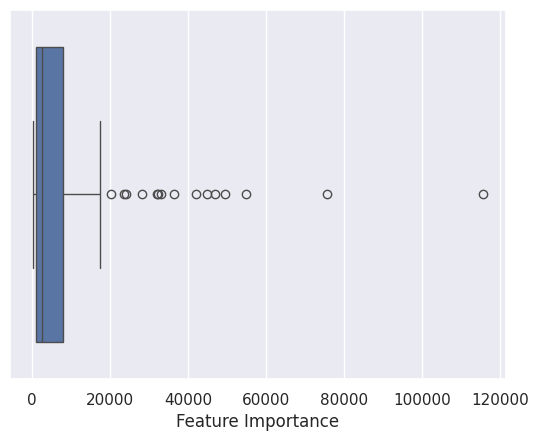

In [22]:
#BoxPlot com valores das feature imnportances
sns.boxplot(data=feature_importance_lgb,x='Feature Importance')


In [23]:
#Treinar LightGBM usando somente parte das features
#As features usadas serão selecionadas de acordos com os valores das features importances
#Por exemplo, se quantile=0.5 somente serão usadas as features cujos coeficientes tenham valores acima da mediana dos coeficientes

resultados_lgb=treinar_modelos_feature_selection(lgb_model, x_train, y_train, feature_importance_lgb,feature_importance_column='Feature Importance')


Número de features selecionadas: 108


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 10%|█         | 1/10 [00:24<03:41, 24.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 20%|██        | 2/10 [00:50<03:21, 25.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 30%|███       | 3/10 [01:14<02:53, 24.73s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1188
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 40%|████      | 4/10 [01:37<02:25, 24.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 50%|█████     | 5/10 [02:02<02:01, 24.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 60%|██████    | 6/10 [02:26<01:37, 24.38s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1186
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 70%|███████   | 7/10 [02:51<01:13, 24.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 80%|████████  | 8/10 [03:15<00:48, 24.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1185
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

 90%|█████████ | 9/10 [03:38<00:23, 23.95s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_l

100%|██████████| 10/10 [04:02<00:00, 24.28s/it]



Número de features selecionadas: 81


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 10%|█         | 1/10 [00:24<03:39, 24.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 20%|██        | 2/10 [00:49<03:16, 24.61s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 30%|███       | 3/10 [01:13<02:52, 24.61s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


 40%|████      | 4/10 [01:37<02:25, 24.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 50%|█████     | 5/10 [02:01<02:01, 24.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1137
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 60%|██████    | 6/10 [02:26<01:37, 24.42s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 70%|███████   | 7/10 [02:51<01:13, 24.48s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 80%|████████  | 8/10 [03:16<00:49, 24.64s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 90%|█████████ | 9/10 [03:41<00:24, 24.83s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1127
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 81
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

100%|██████████| 10/10 [04:05<00:00, 24.55s/it]



Número de features selecionadas: 54


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 10%|█         | 1/10 [00:24<03:40, 24.50s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 20%|██        | 2/10 [00:49<03:16, 24.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 30%|███       | 3/10 [01:13<02:50, 24.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 40%|████      | 4/10 [01:37<02:26, 24.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 50%|█████     | 5/10 [02:01<02:01, 24.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 60%|██████    | 6/10 [02:26<01:37, 24.28s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 70%|███████   | 7/10 [02:50<01:12, 24.24s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1073
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 80%|████████  | 8/10 [03:14<00:48, 24.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1074
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 90%|█████████ | 9/10 [03:39<00:24, 24.40s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

100%|██████████| 10/10 [04:03<00:00, 24.39s/it]



Número de features selecionadas: 27


  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1021
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 10%|█         | 1/10 [00:19<02:57, 19.70s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 20%|██        | 2/10 [00:39<02:37, 19.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 30%|███       | 3/10 [00:59<02:19, 19.96s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 40%|████      | 4/10 [01:19<02:00, 20.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 50%|█████     | 5/10 [01:39<01:40, 20.06s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13667, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274769
[LightGBM] [Info] Start training from score -3.274769
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 60%|██████    | 6/10 [01:59<01:20, 20.04s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 70%|███████   | 7/10 [02:20<01:00, 20.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 374983, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274693
[LightGBM] [Info] Start training from score -3.274693
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 80%|████████  | 8/10 [02:41<00:40, 20.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

 90%|█████████ | 9/10 [03:00<00:20, 20.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Info] Number of positive: 13668, number of negative: 361316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 374984, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036450 -> initscore=-3.274696
[LightGBM] [Info] Start training from score -3.274696
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_le

100%|██████████| 10/10 [03:20<00:00, 20.09s/it]


Text(0, 0.5, 'ROC AUC')

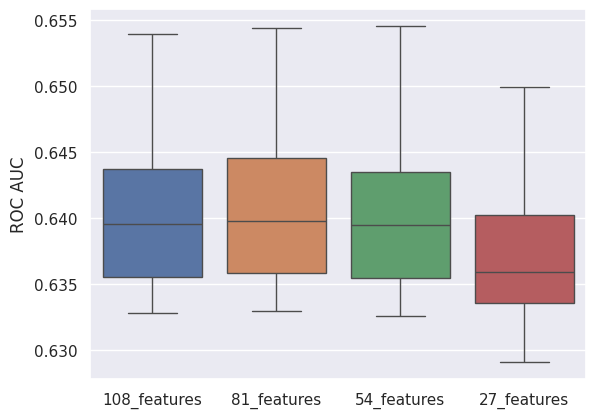

In [24]:
resultados_lgb=pd.DataFrame(resultados_lgb)
sns.boxplot(resultados_lgb)
plt.ylabel("ROC AUC")

In [25]:
resultados_lgb.describe()

,108_features,81_features,54_features,27_features
count,10.000000,10.000000,10.000000,10.000000
mean,0.640738,0.640967,0.640670,0.637348
std,0.006623,0.006593,0.006658,0.006338
min,0.632812,0.632951,0.632569,0.629113
25%,0.635531,0.635874,0.635482,0.633600
50%,0.639550,0.639810,0.639455,0.635924
75%,0.643721,0.644543,0.643504,0.640218
max,0.653910,0.654398,0.654555,0.649892


Melhores resultados:

1.   108 features
2.   81 features

